# **Agentic Pattern: Structured Output Pattern with LangGraph Agents**

A Structured Output Agent in LangChain (or other LLM frameworks) refers to an agent that produces responses in a specific structured format, such as JSON, dictionaries, or other structured data types. These agents are particularly useful when you want to ensure that your responses conform to a defined schema, making it easier to parse, validate, and utilize in downstream applications.<br><br>

**Why Use a Structured Output Agent?**
* **Controlled Responses:** Ensures that the outputs follow a specific format, reducing ambiguity.
* **Data Validation:** Useful when you want the model output to fit predefined structures, like for APIs or database entries.
* **Automation:** Makes integration with systems like dashboards, ETL pipelines, or business workflows easier.

In [ ]:
# install necessary libaries:

%pip install --upgrade --quiet sentence_transformers
%pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-google-genai langchain-chroma bs4 boto3
%pip install --upgrade --quiet langchain-aws
%pip install --upgrade --quiet langgraph langsmith langchain_anthropic
%pip install --upgrade --quiet sentence-transformers langchain_groq

In [ ]:
# Load the Tokens:

from google.colab import userdata
import os

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

## **Load LLM:**

In [ ]:
%pip install langchain_groq

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name="Gemma2-9b-It")

## **Load Tool:**

* Load Tavily Tool,
* Create Custom Tool using Tavily Tool,
* Bind the custom tool with llm

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

In [ ]:
# Tavily Tool:

tavily_tool = TavilySearchResults()

In [ ]:
# Build my custm tool using Talvily Tool:

@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response


get_city_details("City of Siliguri")

[{'url': 'https://www.indovacations.net/english/Siliguri.htm',
  'content': 'Siliguri also known as Gateway of North East India is a city in the Indian state of West Bengal. Siliguri is one of the most prominent cities not only for West Bengal, but for many states of North East as well. Siliguri is located in the plains at the base of the Himalaya mountains, Siliguri links the hill stations such as Gangtok, Darjeeling, Kalimpong, Kurseong and Mirik and North East to the rest of India. Madhuban Park is a park near the city of Siliguri in Darjeeling district, West Bengal which is about 10 to 12 km from the town center, and on the road that leads to the hill station of Darjeeling.'},
 {'url': 'https://www.insidedarjeeling.com/siliguri-the-stepping-stone-to-the-mountains/',
  'content': "Siliguri is the third-largest city of the state. It is also known as the twin city of Jalpaiguri. Siliguri is the focal point linking North Bengal to the rest of the State and is popularly known as The Gat

In [ ]:
# Bind The Tools with LLM:

tools = [get_city_details]
llm_with_tools = llm.bind_tools(tools)

## **Define Structure format of My Response:**

In [ ]:
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState,StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

The **BaseModel** class is a core component of Pydantic, which is used extensively in Python applications for **data validation**, **type checking**, and **parsing**. It's particularly useful when working with APIs, web frameworks like FastAPI, and other scenarios where you need to enforce data structure and ensure data integrity.

In [ ]:
# Define the Structure format of my response.
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")



# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

In [ ]:
# Integrate llm with my Structure Response/Output:

llm_with_structured_output = llm.with_structured_output(CityDetails)

## **LangGraph Integration:**

### **Create Nodes:**

* **call_model:** directly invoke the **llm_with_tools**, and return response (Wheather it is simply llm call or tool calls).

* **should_continue:** checks if the respose call the llm or tool.

* **response:** invoke the **llm_with_structured_output** to generate the output in Structure format.

In [ ]:
# Create Node: call_model

def call_model(state: AgentState):
    print(f" this is 01 input from call model {state}")
    response = llm_with_tools.invoke(state['messages'])
    print(f"this is 02 response from call model  {response}")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [ ]:
# Conditional Node: should_continue

def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]

    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue with the tool
    else:
        return "continue"

In [ ]:
# Create Node: respond

def respond(state: AgentState):
    print(f"here is 03 state from respond {state}")
    response = llm_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    print(f"this is 04 response from respond{response}")
    return {"final_response": response}

In [ ]:
# Create Node: tool_node

tool_node = ToolNode(tools)

### **Create or Define LangGraph Workflow:**

In [ ]:
# Define a new graph
workflow = StateGraph(AgentState)

# Add Nodes into Workflow:
workflow.add_node("llm", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("respond", respond)

# Set the entrypoint:
workflow.set_entry_point("llm")

# This means that this node is the first one called
workflow.add_conditional_edges(
    "llm",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

# Add Cyclic Node:
workflow.add_edge("tools", "llm")

# Set the exitpoint or end point:
workflow.add_edge("respond", END)

# Compile the Graph:
app = workflow.compile()

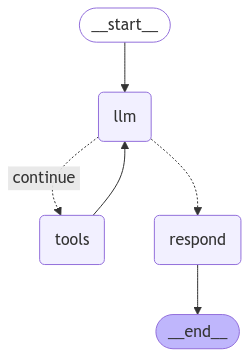

In [ ]:
app

### **Invoking:**

In [ ]:
answer = app.invoke(input={"messages": [("human", "Tell me about the city details for Siligur?")]})
answer

 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for Siligur?', additional_kwargs={}, response_metadata={}, id='6e8ee3ad-8db2-41b4-ba23-1340996d4242')]}
this is 02 response from call model  content='' additional_kwargs={'tool_calls': [{'id': 'call_j9sb', 'function': {'arguments': '{"prompt":"Siligur"}', 'name': 'get_city_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 946, 'total_tokens': 1032, 'completion_time': 0.156363636, 'prompt_time': 0.030191111, 'queue_time': 0.0043107360000000025, 'total_time': 0.186554747}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-ecd76c09-c1ec-4afb-864c-8b3a1e73565c-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Siligur'}, 'id': 'call_j9sb', 'type': 'tool_call'}] usage_metadata={'input_tokens': 946, 'output_tokens': 86, 'total_tokens': 1032}
 thi

{'messages': [HumanMessage(content='Tell me about the city details for Siligur?', additional_kwargs={}, response_metadata={}, id='6e8ee3ad-8db2-41b4-ba23-1340996d4242'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j9sb', 'function': {'arguments': '{"prompt":"Siligur"}', 'name': 'get_city_details'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 946, 'total_tokens': 1032, 'completion_time': 0.156363636, 'prompt_time': 0.030191111, 'queue_time': 0.0043107360000000025, 'total_time': 0.186554747}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ecd76c09-c1ec-4afb-864c-8b3a1e73565c-0', tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Siligur'}, 'id': 'call_j9sb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 946, 'output_tokens': 86, 'total_tokens': 1032}),
  ToolMessage(content='[{"url": "https://siliguritourism.

In [ ]:
answer['final_response']

CityDetails(state_name='West Bengal', state_capital='Kolkata', country_name='India', country_capital='New Delhi')